# Logistic Regression

In [92]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix, precision_score
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import sys
sys.path.append('..')
from utils import sensitivity_score, specificity_score
from sklearn.metrics import make_scorer, get_scorer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay


In [93]:
train_data = pd.read_csv('../dataset/train_data.csv')
train_labels = pd.read_csv('../dataset/train_labels.csv')
train_labels = np.ravel(train_labels)

test_data = pd.read_csv('../dataset/test_data.csv')
test_labels = pd.read_csv('../dataset/test_labels.csv')

In [94]:
train_data.drop(columns=['top_20_entropy'], inplace=True)
test_data.drop(columns=['top_20_entropy'], inplace=True)

## Preprocessing Pipeline

In [95]:
from sklearn.preprocessing import PolynomialFeatures


cat_features = ['is_tarmac', 'length_cat', 'climb_cat']
num_features = [col for col in train_data.columns if col not in cat_features]

num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown='ignore')
# preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
)

## Logistic Regression Model

In [96]:
log_classifier = LogisticRegression(max_iter=2000)

#pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', log_classifier)])

parameters = {
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga', 'newton-cholesky'],
    'classifier__penalty': ['l1', 'l2', None],
    'classifier__tol': [1e-4, 1e-3, 1e-2, 1e-1],
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__class_weight': ['balanced', None]
}


scoring = {
    'sensitivity': make_scorer(sensitivity_score),
    'specificity': make_scorer(specificity_score),
    'accuracy': get_scorer("accuracy"),
    'precision': get_scorer("precision"),
    'sensitivity': get_scorer("recall"),
    'roc_auc': get_scorer("roc_auc"),
    'f1': get_scorer("f1")
}

In [97]:
# Perform randomized search cross-validation
random_search = RandomizedSearchCV(pipe, 
                                   param_distributions=parameters, 
                                   scoring=scoring,
                                   n_iter=100, 
                                   cv=5, # already stratified
                                   verbose=1, 
                                   n_jobs=-1, 
                                   refit='f1',
                                   random_state=42)
random_search.fit(train_data, train_labels)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/Users/effepielle/Developer/university/unipi/dm/dm_project24_group_0/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/effepielle/Developer/university/unipi/dm/dm_project24_group_0/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/effepielle/Developer/university/unipi/dm/dm_project24_group_0/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/effepielle/Developer/university/unipi/dm/dm_project24_group_0/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/effepielle/Developer/university/unipi/dm/dm_p

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['points',
                                                                                'cyclist_age',
                                                                                'cyclist_level',
                                                                                'avg_relative_position',
                                                                                'avg_rel_position_profile',
                                                                                'avg_cyclist_level']),
                                                                              ('cat',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['is_tarmac',
                                                                                'length_cat',
                                                                                'climb_cat'])])),
                                             ('classifier',
                                              LogisticRegr...
                            'f1': make_scorer(f1_score, response_method='predict', average=binary),
                            'precision': make_scorer(precision_score, response_method='predict', average=binary),
                            'roc_auc': make_scorer(roc_auc_score, response_method=('decision_function', 'predict_proba')),
                            'sensitivity': make_scorer(recall_score, response_method='predict', average=binary),
                            'specificity': make_scorer(specificity_score, response_method='predict')},
                   verbose=1)

In [98]:
random_search.best_params_

{'classifier__tol': 0.1,
 'classifier__solver': 'sag',
 'classifier__penalty': None,
 'classifier__class_weight': 'balanced',
 'classifier__C': 0.01}

Accuracy: 0.6609028030578813
Recall: 0.694795617361989
Precision: 0.2531281185230675
Sensitivity: 0.694795617361989
Specificity: 0.6552023531079453
F1 Score: 0.3710684746525629
ROC AUC Score: 0.6749989852349672


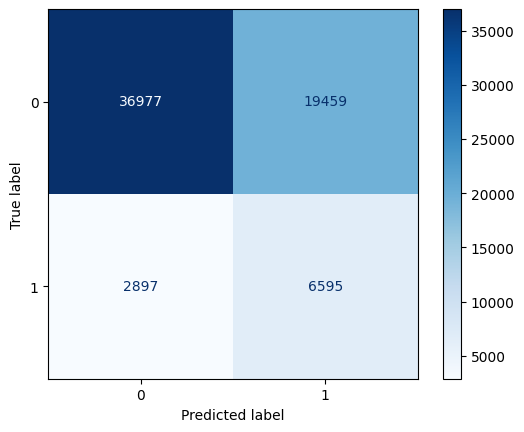

In [99]:
import matplotlib.pyplot as plt

# Predict on the test data
test_predictions = random_search.predict(test_data)

# Calculate evaluation metrics
accuracy = accuracy_score(test_labels, test_predictions)
recall = recall_score(test_labels, test_predictions)
precision = precision_score(test_labels, test_predictions)
sensitivity = sensitivity_score(test_labels, test_predictions)
specificity = specificity_score(test_labels, test_predictions)
f1 = f1_score(test_labels, test_predictions)
roc_auc = roc_auc_score(test_labels, test_predictions)
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Print the evaluation metrics
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"F1 Score: {f1}")
print(f"ROC AUC Score: {roc_auc}")

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()
